# EM or Hamilton Estimation

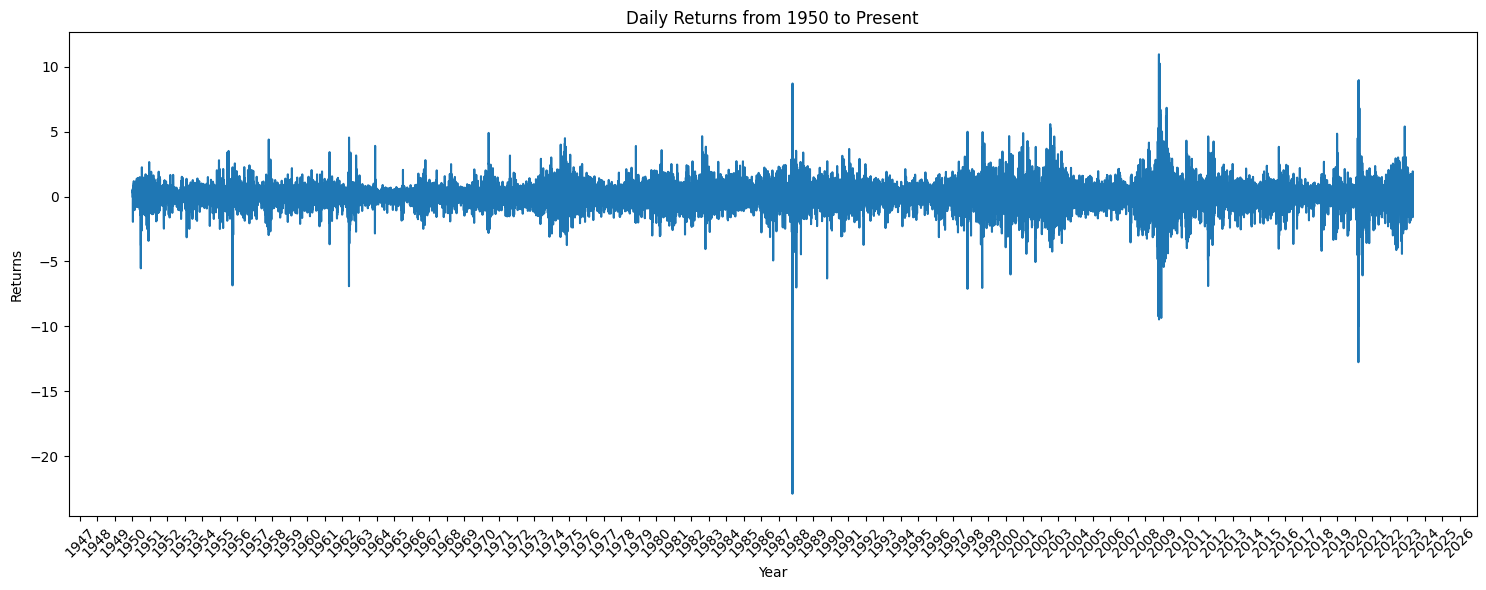

       Unnamed: 0.1  Unnamed: 0       Date    Return       pct       Cum
0                 0           0 1950-01-04  0.000000  0.000000  0.000000
1                 1           1 1950-01-05  0.004737  0.473654  0.004737
2                 2           2 1950-01-06  0.002949  0.294898  0.007686
3                 3           3 1950-01-09  0.005872  0.587201  0.013558
4                 4           4 1950-01-10 -0.002932 -0.293163  0.010626
...             ...         ...        ...       ...       ...       ...
18444         18444       18444 2023-04-24  0.000851  0.085122  5.503385
18445         18445       18445 2023-04-25 -0.015937 -1.593718  5.487448
18446         18446       18446 2023-04-26 -0.003849 -0.384858  5.483599
18447         18447       18447 2023-04-27  0.019377  1.937719  5.502977
18448         18448       18448 2023-04-28  0.008219  0.821933  5.511196

[18449 rows x 6 columns]


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import importlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from hmmlearn import hmm
from arch import arch_model
import Hamilton

df = pd.read_csv('SP.csv', sep=';')

df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['pct'])
plt.xlabel('Year')
plt.ylabel('Returns')
plt.title('Daily Returns from 1950 to Present')

# Setting x-axis to show only the years
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

print(df)

In [29]:
importlib.reload(Hamilton)
from Hamilton import HamiltonFilter as hf

model = hf(data=df['pct'], n_states=2)
y = df['pct']
T = len(y) #length of time series

xi_10      = np.zeros([2,T+1])
xi_11      = np.zeros([2,T])
xi_1T      = np.zeros([2,T])
lik        = np.zeros(T)
# print(xi_10)
# print(xi_11)
# print(xi_1T)
print(lik)

[0. 0. 0. ... 0. 0. 0.]


In [34]:
import numpy as np
from hmmlearn import hmm
from scipy.optimize import minimize

def ar1_residuals(phi, data):
    # Calculate residuals for an AR(1) model
    residuals = data[1:] - phi * data[:-1]
    return residuals


def objective_function(phi, data, states):
    # Calculate residuals differently for each state
    total_residuals = []
    for state in range(model.n_components):
        state_data = data[states == state]
        state_residuals = ar1_residuals(phi[state], state_data)
        total_residuals.extend(state_residuals)

    return np.sum(np.square(total_residuals))

# Your time series data
data = df['pct']

# Initialize the hidden Markov model with 3 states
model = hmm.GaussianHMM(n_components=3, covariance_type="diag")
# Initial fitting of the model
initial_phi = np.array([0.5, 0.5, 0.5])

# Initial guess for the AR(1) parameter
initial_phi = 0.5


max_iterations = 10
def update_hmm_parameters(model, data, residuals, states):
    # Update emission probabilities (means and variances)
    for state in range(model.n_components):
        state_residuals = residuals[states == state]
        model.means_[state] = np.mean(state_residuals)
        model.covars_[state] = np.cov(state_residuals, rowvar=False)

    # Update transition probabilities
    transitions = np.zeros((model.n_components, model.n_components))
    for (prev_state, next_state) in zip(states[:-1], states[1:]):
        transitions[prev_state, next_state] += 1
    
    # Normalize to get probabilities
    row_sums = transitions.sum(axis=1, keepdims=True)
    new_transmat = transitions / row_sums

    # Introduce a learning rate to smooth the transition
    learning_rate = 0.1
    model.transmat_ = (1 - learning_rate) * model.transmat_ + learning_rate * new_transmat

# Your updated iterative estimation process
for iteration in range(max_iterations):
    # Predict the states based on the current model
    data_array = data.to_numpy().reshape(-1, 1)
    data_array = model.fit
    states = model.predict(data_array)
    # Minimize the objective function to find the best AR(1) parameters for each state
    result = minimize(objective_function, initial_phi, args=(data, states), method='L-BFGS-B')
    phi_estimated = result.x

    # Calculate new residuals
    new_residuals = []
    for state in range(model.n_components):
        state_data = data[states == state]
        state_residuals = ar1_residuals(phi_estimated[state], state_data)
        new_residuals.extend(state_residuals)
    
    new_residuals = np.array(new_residuals)

    # Update the HMM parameters based on the new residuals
    update_hmm_parameters(model, data, new_residuals, states)


NotFittedError: This GaussianHMM instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from hmmlearn import hmm


# Assuming 'Return' is the variable you want to model


# Fit an AR(1) model
ar_model = AutoReg(returns, lags=1, old_names=False)
ar_res = ar_model.fit()

# Print the summary of the AR model
print(ar_res.summary())

# Get the residuals from the AR model
ar_resid = ar_res.resid
# garch11 = arch_model(df['Pct Returns'], mean='ARX', lags = 1, vol='Garch', p=1, q=1, dist='t', power=1.0)
# res = garch11.fit(update_freq=10)

# # Step 2: Extract the standardized residuals and conditional volatility
# std_resid = res.resid / res.conditional_volatility
# vol = res.conditional_volatility

# Prepare the residuals for HMM
# Reshape the data for hmmlearn which expects a 2D array
obs = ar_resid.values.reshape(-1, 1)

# Define the number of states for HMM
n_states = 5

# Create and fit the HMM
hmm_model = hmm.GaussianHMM(n_components=n_states, covariance_type="full")
hmm_model.fit(obs)

# Predict the states
hidden_states = hmm_model.predict(obs)

# Output the hidden states
print("Hidden states:")
print(hidden_states)


In [ ]:
smoothed_probs = hmm_model.predict_proba(obs)
# Align the dates to the observations
# Drop the first date to match the length of the smoothed probabilities
aligned_dates = df['Date'][1:]

# Ensure lengths match
assert len(aligned_dates) == len(smoothed_probs), "Date and probability lengths do not match."

# Create a figure with 3 subplots (one for each state)
fig, axs = plt.subplots(hmm_model.n_components, 1, figsize=(15, 10), sharex=True)

for i, ax in enumerate(axs):
    ax.plot(aligned_dates, smoothed_probs[:, i], label=f"State {i}")
    ax.set_ylabel(f"State {i} Probability")
    ax.legend(loc='upper left')

    # Format x-axis to show only the years
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Set common labels and titles
axs[-1].set_xlabel("Year")
plt.suptitle("Smoothed Probabilities for Each State")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Assuming you already have your HMM model fitted as 'model'
# and your observations as 'obs'

# Compute smoothed probabilities


# Prepare the time axis (assuming equal intervals)
time = np.arange(len(obs))

# Plot the stacked area chart
plt.figure(figsize=(15, 5))
plt.stackplot(aligned_dates, smoothed_probs.T, labels=[f"State {i}" for i in range(hmm_model.n_components)])
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title("Smoothed State Probabilities (Stacked Area Plot)")
axs[-1].set_xlabel("Year")
plt.suptitle("Smoothed Probabilities for Each State")

plt.xticks(rotation=45)
plt.ylabel("Probability")
plt.legend(loc='upper left')
plt.show()



In [ ]:


# ... [previous code] ...

# Drop the first row of the DataFrame to match the length of hidden_states
df_aligned = df.iloc[1:].copy()

# Add the predicted states to the aligned DataFrame
df_aligned['State'] = hidden_states

# Fit a t-distributed GARCH(1,1) model for each state
garch_models = {}
for state in range(hmm_model.n_components):
    # Filter data for the current state
    state_data = df_aligned[df_aligned['State'] == state]['Pct Returns']

    # Check if state_data is not empty
    if len(state_data) > 0:
        # Fit a t-distributed GARCH(1,1) model to this state's data
        garch11 = arch_model(state_data, mean='ARX', lags = 1, vol='Garch', p=1, q=1, dist='t', power=1.0)
        garch_res = garch11.fit(update_freq=10, disp='off')

        # Store the fitted model
        garch_models[state] = garch_res
    else:
        print(f"No data available for State {state}, skipping GARCH model fitting.")

# Output the summary of each model
for state, model in garch_models.items():
    print(f"State {state} t-GARCH(1,1) Model:")
    print(model.summary())
    print("\n")


In [ ]:
import numpy as np
import pandas as pd
from arch import arch_model
from hmmlearn.hmm import GaussianHMM

def estimate_garch_hmm(df, max_iters=10, n_states= n_states, convergence_tol=1e-24):
        # Initial GARCH model estimation
    garch_model = arch_model(df['Pct Returns'], mean='ARX', lags=1, vol='Garch', p=1, q=1, dist='t', power=1.0)
    garch_fit = garch_model.fit(disp='off')
    residuals = garch_fit.resid
    residuals = residuals.dropna()
    # Convert residuals to a 2D NumPy array
    residuals_array = residuals.values.reshape(-1, 1)

    # Initialize HMM model
    hmm_model = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=100)
    print(residuals_array)
    hmm_model.fit(residuals_array)
    states = hmm_model.predict(residuals_array)


    for iteration in range(max_iters):
        print(f"Iteration {iteration+1}")

        # Re-estimate GARCH model based on HMM states
        garch_fit = garch_model.fit(disp='off')
        new_residuals = garch_fit.resid

        # Check for convergence
        if np.max(np.abs(new_residuals - residuals)) < convergence_tol:
            print("Convergence achieved.")
            break

        residuals = new_residuals

        # Re-estimate HMM model
        hmm_model.fit(residuals.reshape(-1, 1))
        states = hmm_model.predict(residuals.reshape(-1, 1))

    return garch_fit, hmm_model

# Example usage
# df = pd.DataFrame(...) # your dataframe with 'Pct Returns'
# 
n_states = 3
garch_fit, hmm_model = estimate_garch_hmm(df)

In [ ]:
import matplotlib.pyplot as plt

# Assuming you already have your HMM model fitted as 'model'
# and your observations as 'obs'

# Compute smoothed probabilities


# Prepare the time axis (assuming equal intervals)
time = np.arange(len(obs))

# Plot the stacked area chart
plt.figure(figsize=(15, 5))
plt.stackplot(aligned_dates, smoothed_probs.T, labels=[f"State {i}" for i in range(hmm_model.n_components)])
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title("Smoothed State Probabilities (Stacked Area Plot)")
axs[-1].set_xlabel("Year")
plt.suptitle("Smoothed Probabilities for Each State")

plt.xticks(rotation=45)
plt.ylabel("Probability")
plt.legend(loc='upper left')
plt.show()


In [ ]:
hmm_model.score(obs)

In [ ]:
# # Assuming 'Return' is the variable you want to model
# returns = df['Pct Returns']

# # Fit an AR(1) model
# ar_model = AutoReg(returns, lags=1, old_names=False)
# ar_res = ar_model.fit()

# # Print the summary of the AR model
# print(ar_res.summary())

# # Get the residuals from the AR model
# ar_resid = ar_res.resid

# # Prepare the residuals for HMM
# # Reshape the data for hmmlearn which expects a 2D array
# obs = ar_resid.values.reshape(-1, 1)

for i in range(1, 60):
    # Define the number of states for HMM
    n_states = i
    
    # Create and fit the HMM
    hmm_model = hmm.GaussianHMM(n_components=n_states, covariance_type="full")
    hmm_model.fit(obs)
    
    # Predict the states
    hidden_states = hmm_model.predict(obs)
    # Transition matrix parameters
    transition_params = n_states * (n_states - 1)
    
    # Emission distribution parameters (assuming Gaussian)
    # Mean and variance for each state and each feature
    emission_params = n_states * 5
    
    # Initial state distribution parameters
    initial_state_params = n_states - 1
    
    # Total number of parameters
    total_params = transition_params + emission_params + initial_state_params

    # Output the hidden states
    print(f"States: {n_states},   Log-Likelihood score:   {hmm_model.score(obs)},     Number of parameters,    {total_params}")

In [ ]:
from scipy.stats import chi2

# Model details: states, log-likelihoods, and number of parameters
models = [
    {"states": 1, "log_likelihood": -26152.60693845929, "params": 5},
    {"states": 2, "log_likelihood": -22882.596199320946, "params": 13},
    {"states": 3, "log_likelihood": -22773.878817347417, "params": 23},
    {"states": 4, "log_likelihood": -23220.32156184918, "params": 35},
    {"states": 5, "log_likelihood": -22703.879889250642, "params": 49},
    {"states": 6, "log_likelihood": -22234.702798717928, "params": 65},
    {"states": 7, "log_likelihood": -22201.744485968604, "params": 83}
]

# Perform likelihood ratio tests
for i in range(1, len(models)):
    ll_diff = 2 * (models[i]["log_likelihood"] - models[i-1]["log_likelihood"])
    df_diff = models[i]["params"] - models[i-1]["params"]
    p_value = chi2.sf(ll_diff, df_diff)

    print(f"Test {models[i-1]['states']} state vs {models[i]['states']} states: LR = {ll_diff:.2f}, p-value = {p_value:.4f}")

# Note: Lower p-value (< 0.05 typically) suggests the more complex model is significantly better
